# **Import Package**

In [ ]:
import cv2
import os
import math
import os

# **Persiapan Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Mengimport Data Gambar Kecelakaan Dari RoboFlow Yang Sudah Di Split

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="qLPR1tOzIuP7agswkMbG")
project = rf.workspace("asraf").project("skripsi-klasifikasi-kecelakaan-ohwyd")
version = project.version(3)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Skripsi-Klasifikasi-Kecelakaan-3 in folder:: 100%|██████████| 6290/6290 [00:00<00:00, 8457.89it/s]


In [ ]:
TRAINING_DIR = '/content/Skripsi-Klasifikasi-Kecelakaan-3/train'
VALIDATION_DIR = '/content/Skripsi-Klasifikasi-Kecelakaan-3/valid'
TEST_DIR = '/content/Skripsi-Klasifikasi-Kecelakaan-3/test'

In [ ]:
import os

def count_files_in_class(folder_path):
    # Hitung jumlah file dalam folder
    return len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])

# Tentukan path folder untuk masing-masing subset
train_accident_path = '/content/Skripsi-Klasifikasi-Kecelakaan-3/train/accident'
test_accident_path = '/content/Skripsi-Klasifikasi-Kecelakaan-3/test/accident'
valid_accident_path = '/content/Skripsi-Klasifikasi-Kecelakaan-3/valid/accident'

# Hitung jumlah file di masing-masing subset
train_accident_count = count_files_in_class(train_accident_path)
test_accident_count = count_files_in_class(test_accident_path)
valid_accident_count = count_files_in_class(valid_accident_path)

# Hitung total data
total_accident_count = train_accident_count + test_accident_count + valid_accident_count

# Cetak hasil
print(f"Jumlah data di train/accident: {train_accident_count}")
print(f"Jumlah data di test/accident: {test_accident_count}")
print(f"Jumlah data di valid/accident: {valid_accident_count}")
print(f"Total data accident: {total_accident_count}")


Jumlah data di train/accident: 2452
Jumlah data di test/accident: 378
Jumlah data di valid/accident: 740
Total data accident: 3570


In [ ]:
import os

def count_files_in_class(folder_path):
    # Hitung jumlah file dalam folder
    return len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])

# Tentukan path folder untuk masing-masing subset
train_noAccident_path = '/content/Skripsi-Klasifikasi-Kecelakaan-3/train/no-accident'
test_noAccident_path = '/content/Skripsi-Klasifikasi-Kecelakaan-3/test/no-accident'
valid_noAccident_path = '/content/Skripsi-Klasifikasi-Kecelakaan-3/valid/no-accident'

# Hitung jumlah file di masing-masing subset
train_noAccident_count = count_files_in_class(train_noAccident_path)
test_noAccident_count = count_files_in_class(test_noAccident_path)
valid_noAccident_count = count_files_in_class(valid_noAccident_path)

# Hitung total data
total_noAccident_count = train_noAccident_count + test_noAccident_count + valid_noAccident_count

# Cetak hasil
print(f"Jumlah data di train/no-accident: {train_noAccident_count}")
print(f"Jumlah data di test/no-accident: {test_noAccident_count}")
print(f"Jumlah data di valid/no-accident: {valid_noAccident_count}")
print(f"Total data no-accident: {total_noAccident_count}")


Jumlah data di train/no-accident: 1944
Jumlah data di test/no-accident: 250
Jumlah data di valid/no-accident: 515
Total data no-accident: 2709


# **Pengembangan Model Klasifikasi**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  train_datagen = ImageDataGenerator(
                      fill_mode='nearest',
                      rescale=1/255)

  train_generator = train_datagen.flow_from_directory(
     directory=TRAINING_DIR,
     batch_size=32,
     class_mode='binary',  # Ubah ke binary
     target_size=(224, 224)
)

  validation_datagen = ImageDataGenerator(rescale=1/255)

  validation_generator = validation_datagen.flow_from_directory(
    directory=VALIDATION_DIR,
    batch_size=32,
    class_mode='binary',  # Ubah ke binary
    target_size=(224, 224)
)

  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 4396 images belonging to 2 classes.
Found 1255 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
input_tensor = tf.keras.layers.Input(shape=(224, 224, 3))

base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model.trainable = False

x = base_model.output
x =  tf.keras.layers.GlobalAveragePooling2D()(x)
x =  tf.keras.layers.Dropout(0.5)(x)
x =  tf.keras.layers.Dense(128, activation='relu')(x)
x =  tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 61s 117ms/step - accuracy: 0.5945 - loss: 0.6775 - val_accuracy: 0.7466 - val_loss: 0.5473
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.7051 - loss: 0.5568 - val_accuracy: 0.7657 - val_loss: 0.4922
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7596 - loss: 0.4836 - val_accuracy: 0.7402 - val_loss: 0.4784
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.7868 - loss: 0.4553 - val_accuracy: 0.8080 - val_loss: 0.4187
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.8139 - loss: 0.4133 - val_accuracy: 0.8375 - val_loss: 0.4039
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8395 - loss: 0.3537 - val_accuracy: 0.8733 - val_loss: 0.3353
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.8617 - loss: 0.3169 - val_accuracy: 0.8829 - val_loss: 0.3024
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.8605 - loss: 0.3241 - va

Accuracy plot saved to /content/result/accuracy_plot.png


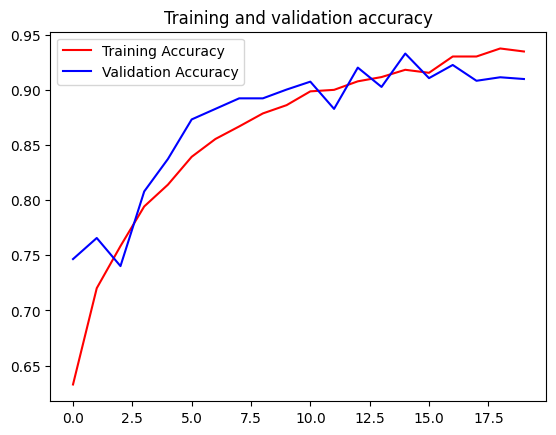

Loss plot saved to /content/result/loss_plot.png


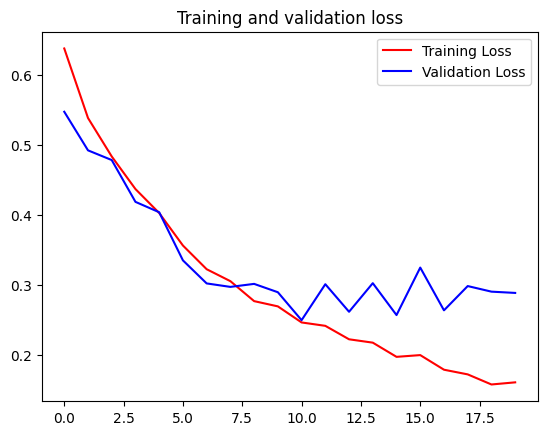

In [ ]:
import matplotlib.pyplot as plt
import os

# Data akurasi dan loss dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Epochs
epochs = range(len(acc))

# Buat folder evalreport jika belum ada
output_dir = '/content/result'
os.makedirs(output_dir, exist_ok=True)

# Plot dan simpan grafik akurasi
plt.figure()
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Simpan grafik akurasi
accuracy_plot_path = os.path.join(output_dir, 'accuracy_plot.png')
plt.savefig(accuracy_plot_path)
print(f"Accuracy plot saved to {accuracy_plot_path}")

# Tampilkan grafik akurasi
plt.show()

# Plot dan simpan grafik loss
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

# Simpan grafik loss
loss_plot_path = os.path.join(output_dir, 'loss_plot.png')
plt.savefig(loss_plot_path)
print(f"Loss plot saved to {loss_plot_path}")

# Tampilkan grafik loss
plt.show()


# **Menyimpan Model dan Riwayat Pelatihan**

In [ ]:
import pickle
# Folder tujuan
result_folder = 'result'
os.makedirs(result_folder, exist_ok=True)

# Simpan model
model_path = os.path.join(result_folder, 'my_model.keras')
model.save(model_path)

# Simpan model
model_path = os.path.join(result_folder, 'my_model.h5')
model.save(model_path)

# Simpan riwayat pelatihan
history_path = os.path.join(result_folder, 'training_history.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history, f)

print(f"Model dan riwayat pelatihan disimpan di folder '{result_folder}'")

Model dan riwayat pelatihan disimpan di folder 'result'


# **Evaluasi Model**

Found 628 images belonging to 2 classes.


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 281ms/step
Classification Report:
               precision    recall  f1-score   support

    accident       0.99      0.91      0.94       378
 no-accident       0.88      0.98      0.92       250

    accuracy                           0.94       628
   macro avg       0.93      0.94      0.93       628
weighted avg       0.94      0.94      0.94       628

Classification report saved to /content/result/evalreport/evaluation_report.txt



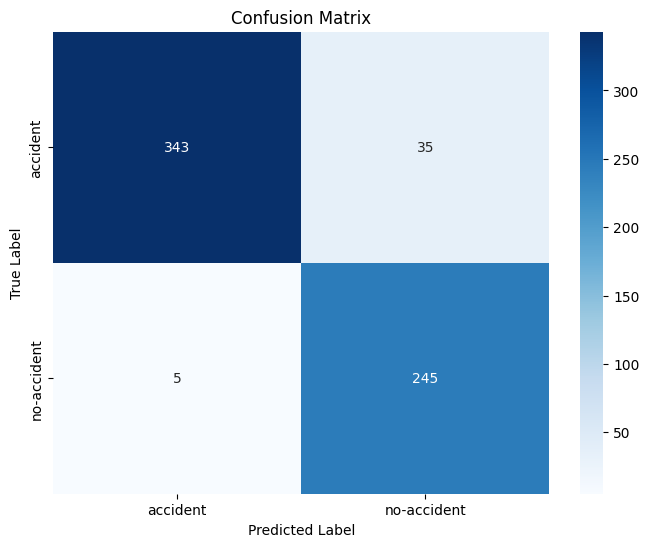

Confusion matrix image saved to /content/result/evalreport/confusion_matrix.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load model yang sudah dilatih
model_path = '/content/drive/MyDrive/Skripsi/Model MobileNetv2/Result Skenario 1 (70:30) Dataset 3/my_model.h5'  # Ganti path sesuai lokasi model Anda
model = load_model(model_path)

# Path ke folder test yang berisi subfolder untuk setiap kelas
test_data_dir = '/content/Skripsi-Klasifikasi-Kecelakaan-3/test'  # Ganti path sesuai lokasi data test Anda

# Set up data generator untuk data test
datagen = ImageDataGenerator(rescale=1./255)  # Normalisasi pixel menjadi [0, 1]
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),  # Ukuran gambar yang sesuai dengan input model
    batch_size=32,
    class_mode='binary',  # Kelas biner: accident (1) dan no-accident (0)
    shuffle=False  # Jangan acak, penting untuk evaluasi
)

# Prediksi data test
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Konversi probabilitas menjadi kelas (0 atau 1)

# Mendapatkan label asli dari data test
true_classes = test_generator.classes

# Nama kelas
class_labels = list(test_generator.class_indices.keys())  # Mendapatkan nama kelas dari generator

# Menghitung classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Menghitung confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
# print("Confusion Matrix:\n", conf_matrix)

# Membuat folder untuk menyimpan hasil evaluasi
output_dir = '/content/result/evalreport'
os.makedirs(output_dir, exist_ok=True)

# Simpan classification report ke file teks
report_path = os.path.join(output_dir, 'evaluation_report.txt')
with open(report_path, 'w') as f:
    f.write("Classification Report:\n")
    f.write(report)
print(f"Classification report saved to {report_path}\n")

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Simpan confusion matrix sebagai gambar
conf_matrix_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.savefig(conf_matrix_path)
plt.show()

print(f"Confusion matrix image saved to {conf_matrix_path}")


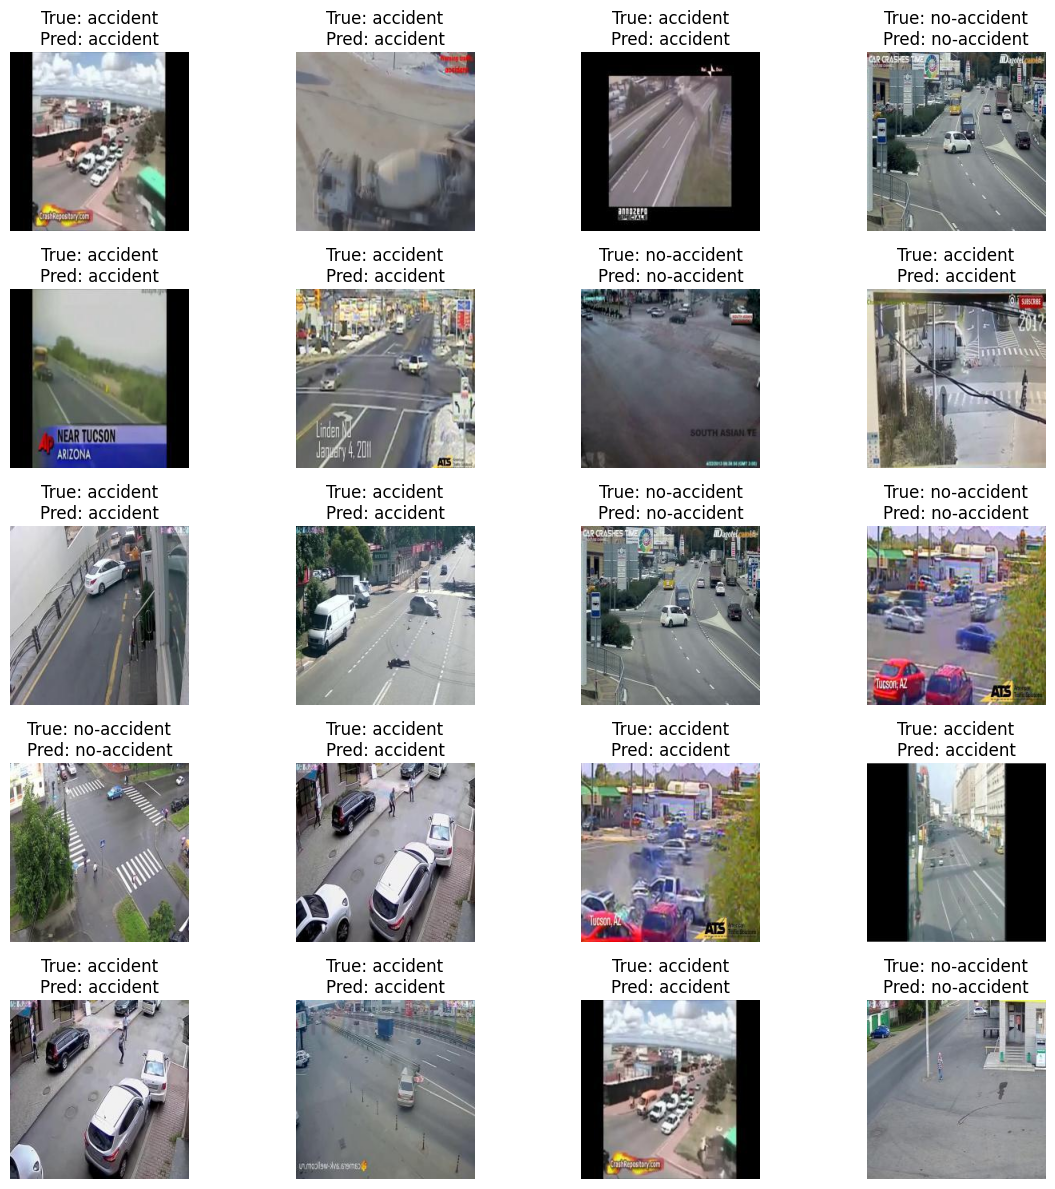

In [ ]:
import random
from tensorflow.keras.preprocessing import image

# Mengambil beberapa gambar acak dari data test
num_samples = 20  # Jumlah gambar yang ingin ditampilkan
sample_indices = random.sample(range(len(test_generator.filenames)), num_samples)

# Buat list untuk menyimpan gambar, true label, dan predicted label
sample_images = []
true_labels = []
predicted_labels = []

for i in sample_indices:
    img_path = os.path.join(test_data_dir, test_generator.filenames[i])  # Path gambar
    img = image.load_img(img_path, target_size=(224, 224))  # Load gambar
    img_array = image.img_to_array(img) / 255.0  # Normalisasi
    sample_images.append(img_array)
    true_labels.append(class_labels[true_classes[i]])  # Ambil true label
    predicted_labels.append(class_labels[predicted_classes[i]])  # Ambil predicted label

# Konversi list sample_images menjadi numpy array
sample_images = np.array(sample_images)

# Plot gambar-gambar yang diuji
plt.figure(figsize=(12, 12))
for i in range(num_samples):
    plt.subplot(5, 4, i+1)  # Atur layout 5x2 untuk 10 gambar
    plt.imshow(sample_images[i])  # Menampilkan gambar
    plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis('off')  # Hilangkan sumbu

plt.tight_layout()
plt.show()




---



---



---



---



In [ ]:
import shutil
import os

# Path folder sumber dan tujuan
source_folder = "/content/result"
destination_folder = "/content/drive/MyDrive/Skripsi/Model MobileNetv2/Result Skenario 1 (70:30) Dataset 3"

# Periksa apakah folder sumber ada
if os.path.exists(source_folder):
    # Buat folder tujuan jika belum ada
    os.makedirs(destination_folder, exist_ok=True)

    # Salin seluruh isi folder
    shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
    print(f"Seluruh isi folder '{source_folder}' berhasil disalin ke '{destination_folder}'.")
else:
    print(f"Folder sumber '{source_folder}' tidak ditemukan.")


Seluruh isi folder '/content/result' berhasil disalin ke '/content/drive/MyDrive/Skripsi/Model MobileNetv2/Result Skenario 1 (70:30) Dataset 3'.
